In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import sqlite3 as sq

In [2]:
conn = sq.connect('database.db')


In [3]:

#General
general = pd.read_sql('SELECT * FROM General', conn)
#Caracteristicas
caracteristicas = pd.read_sql('SELECT * FROM Caracteristicas', conn)
#Educacion
Educacion = pd.read_sql('SELECT * FROM Educacion', conn)
#Trabajo
Trabajo = pd.read_sql('SELECT * FROM Trabajo', conn)
#Atencion_infancia
Codigos = pd.read_sql('SELECT * FROM Codigos', conn)
#Educacion
Educacion = pd.read_sql('SELECT * FROM Educacion', conn)
#Vivienda
Vivienda = pd.read_sql('SELECT * FROM Vivienda', conn)
#Con_vida
Con_vida = pd.read_sql('SELECT * FROM Con_vida', conn)
#variebles
Variables = pd.read_sql('SELECT * FROM variebles', conn)
# servicion hogar
servicios_hogar = pd.read_sql('SELECT * FROM Servicios_hogar', conn)


In [4]:
Variables_ = Variables[['DIRECTORIO', 'SECUENCIA_P', 'ORDEN', 'MPIO', 'SEGMENTO']]
Caracteristicas_ = caracteristicas[['DIRECTORIO', 'SECUENCIA_ENCUESTA', 'SECUENCIA_P', 'ORDEN', 'P6020', 'P6034', 'P6040', 'P6087']]
Educacion_ = Educacion[['DIRECTORIO', 'SECUENCIA_ENCUESTA', 'SECUENCIA_P', 'ORDEN', 'P6160', 'P8586',  'P8587',  'P6211', 'P1088', 'P6216','P5673']]
Trabajo_ = Trabajo[['DIRECTORIO', 'SECUENCIA_ENCUESTA', 'SECUENCIA_P', 'ORDEN', 'FEX_C', 'P6240', 'P6250', 'P6260', 'P6270', 'P6280', 'P6370S2', 'P6390S2', 'P6435', 'P6440','P6450', 'P6460', 'P6460S1', 'P8624','P6595S1', 'P6605S1',  'P1087S4A1', 'P1087S5A1', 'P6750', 'P550','P8632', 'P8634', 'P3193S3',  'P8636', 'P8636S1', 'P7250','P7310', 'P7270S2', 'P8640', 'P8640S1', 'P8654', 'P8654S1','P421S2', 'P421S2A1']]
Servicios_ = servicios_hogar[['DIRECTORIO', 'SECUENCIA_ENCUESTA', 'SECUENCIA_P', 'ORDEN', 'I_HOGAR',
       'I_UGASTO', 'PERCAPITA', 'I_OU', 'CANT_PERSONAS_HOGAR']]
Codigos = pd.read_sql('SELECT * FROM Codigos', conn)
Codigos_ = (Codigos[[ 'COD_MPIO', 'NOMB_DEP','NOMB_MUN', 'LONGITUD',  'LATITUD']]
  .groupby(['COD_MPIO', 'NOMB_DEP','NOMB_MUN'])
  .agg(LATITUD = ('LATITUD','first'), LONGITUD = ('LONGITUD','first'))
  .reset_index()
 )


In [5]:
Codigos.loc[:,'LONGITUD'] = Codigos['LONGITUD'].replace(",",".",regex = True).astype(float)
Codigos_.loc[:,'LATITUD'] = Codigos['LATITUD'].replace(",",".",regex = True).astype(float)

In [6]:
data = (Variables_
 .merge(Caracteristicas_, how='inner', on=['DIRECTORIO', 'SECUENCIA_P', 'ORDEN'])
 .merge(Educacion_, how='inner', on=['DIRECTORIO', 'SECUENCIA_P','SECUENCIA_ENCUESTA', 'ORDEN'])
 .merge(Trabajo_, how='inner', on=['DIRECTORIO', 'SECUENCIA_P','SECUENCIA_ENCUESTA', 'ORDEN'])
 .merge(Servicios_, how='inner', on=['DIRECTORIO', 'SECUENCIA_P','SECUENCIA_ENCUESTA', 'ORDEN'])
 .merge(Codigos_, how='inner', left_on='MPIO', right_on='COD_MPIO'))

# SE ELIMINAN PERSONAS MENORES DE 18 AÑOS CUMPLIDOS
data = data[data['P6040'] >= 18]

In [7]:
# Honorarios anulaes
data[['P1087S4A1','P1087S5A1','P8654S1','P550']]  =  data[['P1087S4A1','P1087S5A1','P8654S1','P550']] /12
data['Total_ingresos'] =  (data[['P1087S4A1','P1087S5A1','P6595S1','P6605S1','P6750','P8624','P8636S1','P550','P8640S1','P8654S1']]
                           .fillna(0)
                           .sum(axis = 1)
                           .astype(int))

data[['I_HOGAR', 'I_OU', 'I_UGASTO']] = data[['I_HOGAR', 'I_OU', 'I_UGASTO']].replace(0, np.nan)
data['Ingresos_2'] = data[['I_HOGAR', 'I_OU', 'I_UGASTO']].bfill(axis=1).iloc[:, 0]
data.loc[data['Total_ingresos'] == 0, 'Total_ingresos'] = data.loc[data['Total_ingresos'] == 0, 'Ingresos_2']
data['Total_ingresos'].fillna(0, inplace=True)

data_ = data.drop(columns = ['Ingresos_2','FEX_C','I_HOGAR','I_OU','I_UGASTO','ORDEN','P421S2','P421S2A1','P6034','SECUENCIA_ENCUESTA',
                             'P6270','P7310','P8640','PERCAPITA','SECUENCIA_P','SEGMENTO','P1087S4A1',
                             'P1087S5A1','P6595S1','P6605S1','P6750','P8624','P8636S1','P550','P8640S1','P8654S1']).fillna(0)

data_.loc[:,'LONGITUD'] = data_['LONGITUD'].replace(",",".",regex = True).astype(float)
data_.loc[:,'LATITUD'] = data_['LATITUD'].replace(",",".",regex = True).astype(float)

region_andina = [
    'TOLIMA', 'RISARALDA', 'VALLE DEL CAUCA', 'HUILA', 'NARIÑO',
    'QUINDÍO', 'BOYACÁ', 'SANTANDER', 'CUNDINAMARCA', 'CALDAS',
    'ANTIOQUIA', 'CAUCA'
]

rodean = [
    'TOLIMA', 'HUILA', 'BOYACÁ',  'CUNDINAMARCA', 'CALDAS','ANTIOQUIA','META'
]

seleccion = data_[data_['NOMB_DEP'].isin(rodean)].fillna(0)

cart = seleccion.groupby(['NOMB_MUN','COD_MPIO','LATITUD','LONGITUD']).agg(MEDIA = ('Total_ingresos','mean')).reset_index()
cart.head()

,NOMB_MUN,COD_MPIO,LATITUD,LONGITUD,MEDIA
0,ABEJORRAL,5002,6.343922,-75.428740,1.088928e+06
1,ACACÍAS,50006,0.000000,-73.765936,1.935766e+06
2,ACEVEDO,41006,6.352823,-75.888535,1.698266e+06
3,AGUADAS,17013,6.407266,-75.454872,2.243930e+06
4,AIPE,41016,6.484232,-75.239031,8.443264e+05


In [8]:
cart.head()

,NOMB_MUN,COD_MPIO,LATITUD,LONGITUD,MEDIA
0,ABEJORRAL,5002,6.343922,-75.428740,1.088928e+06
1,ACACÍAS,50006,0.000000,-73.765936,1.935766e+06
2,ACEVEDO,41006,6.352823,-75.888535,1.698266e+06
3,AGUADAS,17013,6.407266,-75.454872,2.243930e+06
4,AIPE,41016,6.484232,-75.239031,8.443264e+05


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Filtrar para eliminar valores negativos o cero antes de calcular el logaritmo
seleccion = seleccion[seleccion['Total_ingresos'] > 0]

# Calcular el logaritmo de 'Total_ingresos'
seleccion.loc[:,'Log_Total_ingresos'] = np.log(seleccion['Total_ingresos'])

# Eliminar valores -inf y NaN generados por el logaritmo
seleccion = seleccion[seleccion['Log_Total_ingresos'] != -np.inf]
seleccion = seleccion[seleccion['Log_Total_ingresos'].notna()]

# # Mostrar el histograma
# seleccion[['Log_Total_ingresos']].hist(figsize=(5, 5))
# plt.show()


In [ ]:
# Calcular la matrix w
import numpy as np
import pandas as pd
from math import radians, sin, cos, sqrt, atan2
def haversine(lat1, lon1, lat2, lon2):
    # Convertir grados a radianes
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Diferencias de latitudes y longitudes
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Fórmula de Haversine
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Radio de la Tierra en km
    R = 6371.0
    distance = R * c
    return distance


# Crear un DataFrame
df = cart

# Inicializar una matriz de distancias
n = len(df)
distance_matrix = np.zeros((n, n))

# Calcular las distancias y llenar la matriz
for i in range(n):
    for j in range(i, n):
        lat1, lon1 = df.iloc[i]['LATITUD'], df.iloc[i]['LONGITUD']
        lat2, lon2 = df.iloc[j]['LATITUD'], df.iloc[j]['LONGITUD']
        distance = haversine(lat1, lon1, lat2, lon2)
        distance_matrix[i][j] = distance_matrix[j][i] = distance  # Matriz simétrica

# Convertir la matriz de distancias a un DataFrame para una visualización más clara
distance_df = pd.DataFrame(distance_matrix, columns=df['NOMB_MUN'], index=df['NOMB_MUN'])

In [ ]:
w = 1/(distance_df**2)
w = w.replace(np.inf, 0)
w1 = np.exp(-distance_df**2)
w1 = w1.replace(np.inf, 0)
w2 = 1/(distance_df)
w2 = w2.replace(np.inf, 0)

In [ ]:
w_ = np.array(w)

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
gdf = gpd.read_file('/content/drive/MyDrive/SEMINARIO/Mapas/Municipio, Distrito y Area no municipalizada.shp')


In [ ]:
gdf['MpCodigo'] = pd.to_numeric(gdf['MpCodigo'], errors='coerce')
df_ = gdf.merge(df,left_on='MpCodigo', right_on='COD_MPIO', how='inner')


In [ ]:
wq =  lp.weights.Queen.from_dataframe(df_)
wq.transform = 'r'

In [ ]:

moran = Moran(df_['MEDIA'],wq)
print(moran.I)
print(moran.p_sim) # si hay diferencia espacial


0.3228236648160303
0.001


In [ ]:
moran_local.p_sim

array([0.247, 0.338, 0.104, 0.099, 0.288, 0.328, 0.097, 0.191, 0.072,
       0.259, 0.099, 0.161, 0.36 , 0.479, 0.491, 0.111, 0.151, 0.169,
       0.268, 0.409, 0.137, 0.188, 0.379, 0.039, 0.057, 0.115, 0.487,
       0.425, 0.304, 0.006, 0.008, 0.495, 0.361, 0.009, 0.248, 0.304,
       0.455, 0.05 , 0.204, 0.147, 0.077, 0.267, 0.222, 0.005, 0.244,
       0.215, 0.416, 0.5  , 0.46 , 0.488, 0.499, 0.175, 0.218, 0.148,
       0.453, 0.38 , 0.352, 0.466, 0.322, 0.322, 0.425, 0.423, 0.287,
       0.153, 0.5  , 0.102, 0.296, 0.324, 0.188, 0.253, 0.279, 0.092,
       0.092, 0.439, 0.261, 0.415, 0.184, 0.017, 0.013, 0.431, 0.034,
       0.011, 0.401, 0.006, 0.149, 0.437, 0.372, 0.447, 0.038, 0.383,
       0.084, 0.033, 0.245, 0.001, 0.025, 0.006, 0.277, 0.143, 0.403,
       0.386, 0.107, 0.271, 0.024, 0.224, 0.186, 0.319, 0.074, 0.228,
       0.444, 0.03 , 0.164, 0.376, 0.212, 0.202, 0.116, 0.381, 0.303,
       0.087, 0.092, 0.04 , 0.194, 0.334, 0.193, 0.069, 0.255, 0.408,
       0.012, 0.248,

/usr/local/lib/python3.11/dist-packages/esda/moran.py:1084: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


<Axes: ylabel='Density'>

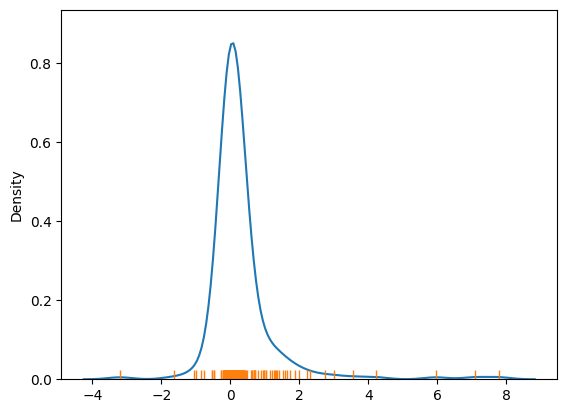

In [ ]:
from esda import Moran_Local
import seaborn as sns
import matplotlib.pyplot as plt
moran_local = Moran_Local(df_['MEDIA'], wq)


# Draw KDE line
ax = sns.kdeplot(moran_local.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
sns.rugplot(moran_local.Is, ax=ax)


In [ ]:
df_

,MpCodigo,MpNombre,MpArea,MpNorma,MpCategor,SHAPE_Leng,SHAPE_Area,MpAltitud,Restriccio,Depto,geometry,NOMB_MUN,COD_MPIO,LATITUD,LONGITUD,MEDIA
0,41006,Acevedo,521.806772,None,1,133174.191658,5.218068e+08,1563,“No es apropiada su aplicación para la ubicaci...,Huila,"POLYGON ((4684422.998 1750557.821, 4684413.957...",ACEVEDO,41006,6.352823,-75.888535,1.033320e+06
1,41770,Suaza,429.623461,None,1,104237.587588,4.296235e+08,1000,“No es apropiada su aplicación para la ubicaci...,Huila,"POLYGON ((4686305.708 1779011.321, 4686421.564...",SUAZA,41770,7.099566,-75.795057,8.540710e+05
2,41551,Pitalito,630.731671,None,1,166026.385406,6.307317e+08,1271,“No es apropiada su aplicación para la ubicaci...,Huila,"POLYGON ((4652020.538 1779145.329, 4652056.466...",PITALITO,41551,6.536929,-76.049004,1.181619e+06
3,41807,Timaná,185.721675,None,1,74788.954963,1.857217e+08,1011,“No es apropiada su aplicación para la ubicaci...,Huila,"POLYGON ((4682215.036 1784441.681, 4682239.833...",TIMANÁ,41807,5.714808,-75.932085,1.114361e+06
4,41244,Elías,80.441800,None,1,57417.400080,8.044180e+07,1500,“No es apropiada su aplicación para la ubicaci...,Huila,"POLYGON ((4671863.825 1784887.526, 4672115.811...",ELÍAS,41244,5.791345,-75.938019,9.159306e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,5264,Entrerrios,214.228511,None,1,89624.479746,2.142285e+08,2292,“No es apropiada su aplicación para la ubicaci...,Antioquia,"POLYGON ((4719021.298 2296712.264, 4719040.339...",ENTRERRÍOS,5264,6.055461,-75.517806,2.211658e+06
226,25377,La Calera,326.344346,None,1,114248.718392,3.263443e+08,2581,“No es apropiada su aplicación para la ubicaci...,Cundinamarca,"POLYGON ((4888416.941 2091042.97, 4888505.101 ...",LA CALERA,25377,6.140109,-73.967966,1.216067e+06
227,25214,Cota,53.679505,None,1,59635.621783,5.367950e+07,2561,“No es apropiada su aplicación para la ubicaci...,Cundinamarca,"POLYGON ((4878745.164 2093914.824, 4878832.114...",COTA,25214,6.080749,-74.102727,9.998539e+05
228,25175,Chía,80.026461,None,1,56307.877135,8.004830e+07,2557,“No es apropiada su aplicación para la ubicaci...,Cundinamarca,"POLYGON ((4888146.834 2090743.135, 4888145.8 2...",CHÍA,25175,6.492226,-74.050347,2.299391e+06


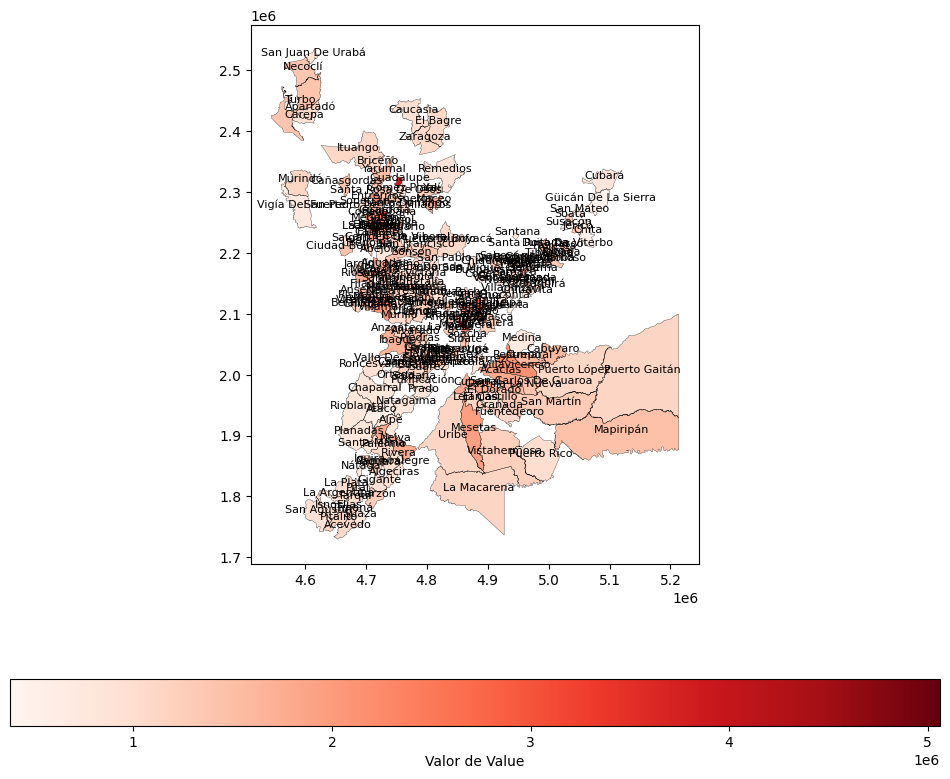

In [ ]:
# Crear la figura y los ejes
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Usar gdf.plot() para crear el mapa de calor
df_.plot(ax=ax, column='MEDIA', legend=True,
         legend_kwds={'label': "Valor de Value",
                      'orientation': "horizontal"},
         cmap='Reds')  # Usamos 'Blues' para la escala de colores azules

df_.boundary.plot(ax=ax, color='black', linewidth=0.2)

# Mostrar nombres de departamentos solo para los más grandes o relevantes
# Esto puede evitar que el mapa se congestione. A continuación, solo etiquetamos los primeros 10 departamentos


# Agregar nombres de los departamentos (centrados) solo para los top_departments
for idx, row in df_.iterrows():
    dept_name = row['MpNombre']
    centroid = row['geometry'].centroid
    ax.annotate(dept_name, xy=(centroid.x, centroid.y),
                xytext=(1, 1), textcoords="offset points",
                fontsize=8, ha='center', color='black')

MODELO LINEAL GENERALIZADO NORMAL

In [ ]:
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Filtrar los datos por el directorio seleccionado (si es necesario)
df = data_[data_['DIRECTORIO'].isin(seleccion['DIRECTORIO'])]

# Separar las variables predictoras (X) y la variable dependiente (y)
X = df.drop(columns=['Total_ingresos', 'COD_MPIO', 'NOMB_DEP','MPIO', 'NOMB_MUN', 'DIRECTORIO','LATITUD','LONGITUD'])
y = df['Total_ingresos']

# Asegurarse de que todas las columnas sean numéricas
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

X_ = X.head(1000)
y_ = y.head(1000)

import statsmodels.api as sm
normal_model = sm.GLM(y_, X_, family=sm.families.Gaussian())
normal_results =  normal_model.fit()
print(normal_results.summary2())


# # Estadística de la prueba de razón de verosimilitud (LRT)
# LR = 2 * (ll_completo - ll_reducido)
# # Grados de libertad es 1 porque solo eliminamos una variable
# from scipy.stats import chi2
# p_value = chi2.sf(LR, df=1)

# print(f"Estadística LRT: {LR}")
# print(f"Valor p de la prueba de razón de verosimilitud: {p_value}")

                           Results: Generalized linear model
Model:                   GLM                  AIC:                31666.8491           
Link Function:           Identity             BIC:                3126615023498582.5000
Dependent Variable:      Total_ingresos       Log-Likelihood:     -15804.              
Date:                    2025-01-16 23:25     LL-Null:            -15944.              
No. Observations:        1000                 Deviance:           3.1266e+15           
Df Model:                28                   Pearson chi2:       3.13e+15             
Df Residuals:            971                  Scale:              3.2200e+12           
Method:                  IRLS                                                          
---------------------------------------------------------------------------------------
                        Coef.       Std.Err.     z    P>|z|      [0.025       0.975]   
-----------------------------------------------------------

MAPA GEOPANDAS

In [ ]:
# prompt: grafic /content/drive/MyDrive/SEMINARIO/Mapas/Municipio, Distrito y Area no municipalizada.shp

import geopandas as gpd
import matplotlib.pyplot as plt

# Lee el archivo shapefile
gdf = gpd.read_file('/content/drive/MyDrive/SEMINARIO/Mapas/Municipio, Distrito y Area no municipalizada.shp')



In [ ]:

gdf['MpCodigo'] = pd.to_numeric(gdf['MpCodigo'], errors='coerce')

Dep = gdf[gdf['MpCodigo'].isin(seleccion['COD_MPIO'])]['Depto']
gdf = gdf[gdf['Depto'].isin(Dep)]


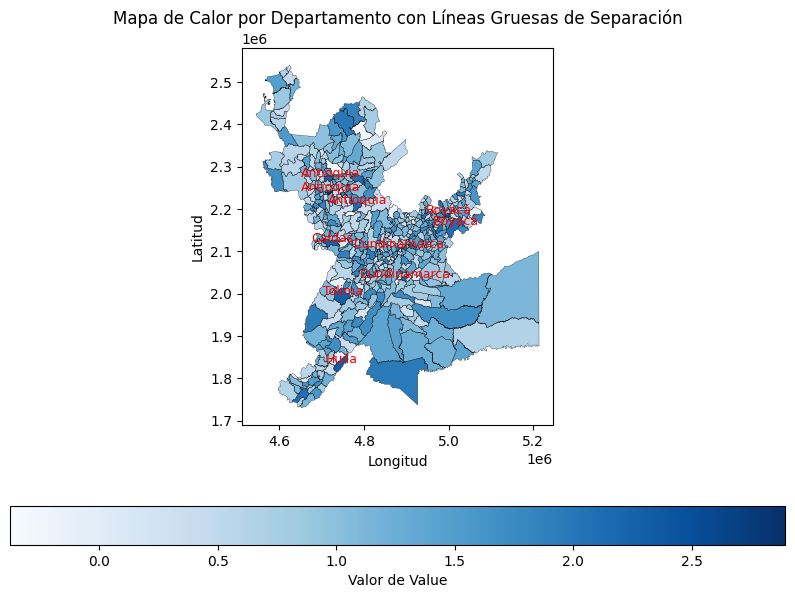

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

# Crear una columna 'Value' numérica de ejemplo (si no la tienes ya)
gdf['Value'] = np.random.normal(loc=1, scale=0.5, size=len(gdf))

# Crear la figura y los ejes
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Usar gdf.plot() para crear el mapa de calor
gdf.plot(ax=ax, column='Value', legend=True,
         legend_kwds={'label': "Valor de Value",
                      'orientation': "horizontal"},
         cmap='Blues')  # Usamos 'Blues' para la escala de colores azules

# Trazar las fronteras de los departamentos con una línea gruesa
gdf.boundary.plot(ax=ax, color='black', linewidth=0.2)

# Mostrar nombres de departamentos solo para los más grandes o relevantes
# Esto puede evitar que el mapa se congestione. A continuación, solo etiquetamos los primeros 10 departamentos
top_departments = gdf.nlargest(10, 'Value')

# Agregar nombres de los departamentos (centrados) solo para los top_departments
for idx, row in top_departments.iterrows():
    dept_name = row['Depto']
    centroid = row['geometry'].centroid
    ax.annotate(dept_name, xy=(centroid.x, centroid.y),
                xytext=(1, 1), textcoords="offset points",
                fontsize=9, ha='center', color='red')

# Configurar el título y las etiquetas
ax.set_title('Mapa de Calor por Departamento con Líneas Gruesas de Separación')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Mostrar el gráfico
plt.show()


In [ ]:
# Aquí, usamos 'MpNombre' como columna para la coloración del mapa
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

# Crear una columna 'Value' numérica de ejemplo (si no la tienes ya)
gdf['Value'] = np.random.normal(loc=10, scale=10.5, size=len(gdf))

# Crear la figura y los ejes
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Usar gdf.plot() para crear el mapa de calor
gdf.plot(ax=ax, column='Value', legend=True,
         legend_kwds={'label': "Valor de Value",
                      'orientation': "horizontal"},
         cmap='Blues')  # Puedes cambiar 'YlOrRd' a otro colormap como 'viridis', 'coolwarm', etc.

# Configurar el título y las etiquetas
ax.set_title('Mapa de Calor por Variable Numérica')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Mostrar el gráfico
plt.show()


In [ ]:
# MACHINE LEARNINF TEST


In [ ]:


import pandas as pd
import seaborn as sns
import numpy as np
import sqlite3 as sq
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# Filtrar los datos por el directorio seleccionado (si es necesario)
df = data_[data_['DIRECTORIO'].isin(seleccion['DIRECTORIO'])]

# Separar las variables predictoras (X) y la variable dependiente (y)
X = df.drop(columns=['Total_ingresos', 'COD_MPIO', 'NOMB_DEP', 'NOMB_MUN', 'DIRECTORIO','LATITUD','LONGITUD'])
y = df['Total_ingresos']

# Asegurarse de que todas las columnas sean numéricas y manejar valores no numéricos
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')
X = X.fillna(0)  # Rellenar valores faltantes con 0
y = pd.to_numeric(y, errors='coerce')
y = y.fillna(0) # Rellenar valores faltantes con 0


# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Crear y entrenar el modelo de red neuronal
model = MLPRegressor(hidden_layer_sizes=(100,50), activation='relu', solver='adam', max_iter=500, random_state=42)
model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

Mean Squared Error: 2814511344057.7266
Mean Absolute Error: 871019.1718559267
R-squared: 0.23109122833826312


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:


# Filtrar los datos por el directorio seleccionado (si es necesario)
df = data_[data_['DIRECTORIO'].isin(seleccion['DIRECTORIO'])]

# Separar las variables predictoras (X) y la variable dependiente (y)
X = df.drop(columns=['Total_ingresos', 'COD_MPIO', 'NOMB_DEP', 'NOMB_MUN', 'DIRECTORIO','LATITUD','LONGITUD'])
y = df['Total_ingresos']

# Asegurarse de que todas las columnas sean numéricas y manejar valores no numéricos
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')
X = X.fillna(0)  # Rellenar valores faltantes con 0
y = pd.to_numeric(y, errors='coerce')
y = y.fillna(0) # Rellenar valores faltantes con 0


# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Importar Keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Crear y entrenar el modelo de red neuronal con Keras
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],))) # Capa de entrada con 128 neuronas
model.add(Dense(64, activation='relu')) # Primera capa oculta con 64 neuronas
model.add(Dense(32, activation='relu')) # Segunda capa oculta con 32 neuronas
model.add(Dense(1)) # Capa de salida (una neurona para la regresión)

model.compile(optimizer='adam', loss='mse', metrics=['mae']) # Compilar el modelo

model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1) # Entrenar el modelo


# Evaluar el modelo
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


541/541 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10711880171520.0000 - mae: 1543310.0000
Epoch 2/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5112949899264.0000 - mae: 1063316.3750
Epoch 3/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4170899259392.0000 - mae: 958456.7500
Epoch 4/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5534651514880.0000 - mae: 966421.2500
Epoch 5/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5877622898688.0000 - mae: 944531.1875
Epoch 6/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6653721706496.0000 - mae: 957577.5000
Epoch 7/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5732296032256.0000 - mae: 950570.7500
Epoch 8/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12342814310400.0000 - mae: 955866.0625
Epoch 9/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6567600586752.0000 - mae: 917154.8750
Epoch 10/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 10703206350848.0000 - mae: 935151.5000
Epoch 11/100
541

In [ ]:

model.save('/content/drive/MyDrive/model.h5')

In [ ]:
# ARBOL DE DREGRESION
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Crear y entrenar el modelo
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse}, R²: {r2}")


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Crear y entrenar el modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse}, R²: {r2}")


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Crear y entrenar el modelo
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse}, R²: {r2}")

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Crear y entrenar el modelo
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse}, R²: {r2}")



PARTE ESPACIAL DISTANCIAS

In [ ]:
cart = seleccion[['NOMB_MUN','LATITUD','LONGITUD']].drop_duplicates()
cart.head()

In [ ]:
import numpy as np
import pandas as pd
from math import radians, sin, cos, sqrt, atan2

# Función para calcular la distancia entre dos puntos usando la fórmula de Haversine




In [ ]:
data.to_csv('data.csv',index=False)

In [ ]:
# cursor = conn.cursor()
# cursor.execute('DROP TABLE IF EXISTS Vivienda')
# cursor.execute('DROP TABLE IF EXISTS Con_vida')
# cursor.execute('DROP TABLE IF EXISTS variebles')

# conn.commit()

# vivienda = pd.read_csv('/content/Datos de la vivienda.CSV',sep = ';')
# Con_vida = pd.read_csv('/content/Condiciones de vida del hogar y tenencia de bienes.CSV',sep = ';')
# variebles = pd.read_csv('/content/Variables diseño muestral.CSV',sep = ';')


# vivienda.to_sql(name='Vivienda', con=conn, if_exists ='replace', index = False)
# Con_vida.to_sql(name='Con_vida', con=conn, if_exists ='replace', index = False)
# variebles.to_sql(name='variebles', con=conn, if_exists ='replace', index = False)

In [ ]:
varibales = pd.read_sql('SELECT * FROM variebles', conn)
vivienda = pd.read_sql('SELECT * FROM Vivienda', conn)
Con_vida = pd.read_sql('SELECT * FROM Con_vida', conn)

In [ ]:
# Crear un cursor para ejecutar comandos SQL
cursor = conn.cursor()

# Ejecutar el comando para obtener las tablas
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Obtener todos los resultados
tablas = cursor.fetchall()

# Imprimir las tablas
for tabla in tablas:
    print(tabla[0])

# Cerrar la conexión
conn.close()

SEGURIDAD

In [ ]:
#Codigos = pd.read_sql('SELECT distinct COD_DEP,COD_MPIO,NOMB_DEP,NOMB_MUN FROM Codigos', conn)

Codigos = pd.read_sql('SELECT distinct COD_DEP,NOMB_DEP,LATITUD,LONIGITUD FROM Codigos', conn)

In [ ]:
Vivienda = pd.read_sql('SELECT * FROM Vivienda', conn)
Variables = pd.read_sql('SELECT * FROM variebles', conn)
caracteristicas = pd.read_sql('SELECT * FROM Caracteristicas', conn)
Con_vida = pd.read_sql('SELECT  * from Con_vida', conn)
Trabajo = pd.read_sql('SELECT * FROM Trabajo', conn)

In [ ]:
Vivienda['P4065S1']

In [ ]:
from sklearn.preprocessing import LabelEncoder

LabelEncoder = LabelEncoder()
sel['NOMB_DEP'] = LabelEncoder.fit_transform(sel['NOMB_DEP'])

In [ ]:
sel['NOMB_DEP'].unique()

VARIABLE SEGURIDAD

Variable ordinal toma valores entre 0 y 1
 $$
  y_{seg(P1898)} = p_{robos(P9025S1)} + p_{homicidios(P9025S2)} + p_{inundaciones(P4065S1)} + p_{sismo(P4065S2)} + p_{derrumbes(P4065S5)}+ V_{ingresos(P8624)} + v_{seguridad_privada(P5650)} + V_{otros_ingresos(P6605S1)}
 $$





In [ ]:
d1 = caracteristicas[['DIRECTORIO', 'SECUENCIA_ENCUESTA','P1898']].rename(columns={'P1898':'Y_seguridad'})
d2 = Con_vida[['DIRECTORIO', 'SECUENCIA_ENCUESTA','P9025S1','P9025S2']]
d3 = Vivienda[['DIRECTORIO', 'SECUENCIA_ENCUESTA','P1_DEPARTAMENTO', 'P1_MUNICIPIO','P4065S1','P4065S2','P4065S3']]
d4 = Trabajo[['DIRECTORIO', 'SECUENCIA_ENCUESTA','P8624','P6605S1']]
# Falta
data  = (d1
 .merge(d2, how='inner', on=['DIRECTORIO','SECUENCIA_ENCUESTA'])
 .merge(d3, how='inner', on=['DIRECTORIO','SECUENCIA_ENCUESTA'])
 .merge(d4, how='inner', on=['DIRECTORIO','SECUENCIA_ENCUESTA'])
 .merge(Codigos,left_on="P1_DEPARTAMENTO",right_on='COD_DEP'))

sel = data[data['NOMB_DEP'].isin(['CUNDINAMARCA', 'BOYACÁ', 'META', 'TOLIMA', 'HUILA', 'SANTANDER','BOGOTÁ, D. C.'])].fillna(0)
sel.drop(columns=['DIRECTORIO', 'SECUENCIA_ENCUESTA','P1_DEPARTAMENTO',	'P1_MUNICIPIO'],inplace=True)


In [ ]:
sel

Satisfaccion salud



 $$
  y_{salud(P1898)}=tipo_{afi(P6100)}+Vp_{med(P3178S1A1)}+Vp_{salud(P8551)}+Mp_{P799S2}+P_{ecP1930}
 $$




In [ ]:
y_seg = caracteristicas[['DIRECTORIO', 'SECUENCIA_ENCUESTA', 'SECUENCIA_P','P1898','P1896','P1897','P1899','P1901']].rename(columns={'P1898':'S_seguridad'})

In [ ]:
# Variable dependiente y: Nivel de satisfacción en seguridad
y_seg = caracteristicas[['DIRECTORIO', 'SECUENCIA_ENCUESTA', 'SECUENCIA_P','P1898','P1896','P1897','P1899','P1901']].rename(columns={'P1898':'S_seguridad'})
# covariables x:
c_seg = pd.read_sql(qvivienda, conn).merge(Con_vida, how='inner', on=['DIRECTORIO','SECUENCIA_P','SECUENCIA_ENCUESTA'])

# TABLA COMPUESTA
tabla = c_seg.merge(y_seg, how='inner', on=['DIRECTORIO','SECUENCIA_P','SECUENCIA_ENCUESTA'])

# Ajustando valores para extraer geolocalizaciones

def pad_code(code, length):
  code_str = str(code)
  return code_str.zfill(length)

tabla['P1_MUNICIPIO'] = tabla['P1_MUNICIPIO'].apply(lambda x: pad_code(x, 3))

# Concatenate the columns
tabla['concatenated'] = tabla['P1_DEPARTAMENTO'].astype(str) + tabla['P1_MUNICIPIO'].astype(str)
tabla['concatenated'] = tabla['concatenated'].astype(int)


# AGREGA VARIABLES DE LATITUD Y LONGITUD
tabla_ = tabla.merge(Codigos, how='inner', left_on='concatenated', right_on='COD_MPIO')

tabla_.loc[:,'LONGITUD'] = tabla_['LONGITUD'].replace(",",".",regex = True).astype(float)
tabla_.loc[:,'LATITUD'] = tabla_['LATITUD'].replace(",",".",regex = True).astype(float)
#Rodean = ['CUNDINAMARCA', 'BOYACÁ', 'META', 'TOLIMA', 'HUILA', 'SANTANDER','BOGOTÁ, D. C.']

# DEPARTAMENTOS QUE RODEAN BOGOTA
Rodean = ['CUNDINAMARCA', 'BOYACÁ','BOGOTÁ, D. C.']
seleccion = tabla_[tabla_['NOMB_DEP'].isin(Rodean)]



In [ ]:

# seleccion.groupby(['NOMB_DEP'])['P1897'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)#seleccion['S_seguridad']
# seleccion.groupby(['NOMB_DEP'])['S_seguridad'].value_counts(normalize=True).reset_index()

In [ ]:
# cols = ['P9025S1','S_seguridad']
# cols = ['P9010','P9025S1','P9025S2','P2102','P4065S1','P4065S3','P4065S4','P4065S5','LATITUD', 'LONGITUD','S_seguridad']
# #cols = ['P9010','P9025S1','P9025S2','P2102','P4065S1','P4065S3','P4065S4','P4065S5','LATITUD', 'LONGITUD','S_seguridad']

# validate = seleccion[seleccion['NOMB_DEP'] == 'BOGOTÁ, D. C.']
# train = seleccion[seleccion['NOMB_DEP'] != 'BOGOTÁ, D. C.'][cols]

In [ ]:
%pip install prince
import prince

In [ ]:
# import pandas as pd
# import prince
# import matplotlib.pyplot as plt

# # Preparación de los datos
# df = seleccion[['P9010','P9025S1','P9025S1','P4065S1','P4065S2','P4065S3','P4065S4','P4065S5']]  # Datos de desastres naturales

# # Aplicar MCA
# mca = prince.MCA(n_components=2)
# mca_result = mca.fit_transform(df)

# # Reducir a un solo componente (componente 1)
# df['Componente_1'] = mca_result[0]

# # Mostrar el DataFrame con la nueva variable
# print("\nDataFrame con el nuevo componente (Componente_1):")
# print(df[['P9010','P9025S1','P9025S1','P4065S1','P4065S2','P4065S3','P4065S4','P4065S5', 'Componente_1']])

# # Obtener los valores propios (autovalores) y calcular la varianza explicada
# eigenvalues = mca.eigenvalues_  # Obtener los autovalores
# explained_variance = eigenvalues / eigenvalues.sum()  # Varianza explicada por cada componente
# print("\nProporción de varianza explicada por cada componente:")
# print(explained_variance)

# # # Visualización de los datos en el espacio reducido (2 componentes)
# # plt.figure(figsize=(8, 6))
# # plt.scatter(mca_result[0], mca_result[1], color='blue')
# # plt.title('Distribución en el espacio reducido (2 componentes)')
# # plt.xlabel('Componente 1')
# # plt.ylabel('Componente 2')
# # plt.grid(True)
# # plt.show()

# # # Visualización usando solo el primer componente
# # plt.figure(figsize=(8, 6))
# # plt.scatter(mca_result[0], [0] * len(mca_result[0]), color='blue')
# # plt.title('Distribución en el espacio reducido (1 componente)')
# # plt.xlabel('Componente 1')
# # plt.grid(True)
# # plt.show()


In [ ]:
data = tabla_[['S_seguridad','P9010','P9025S1','P9025S1','P4065S1','P4065S2','P4065S3','P4065S4','P4065S5','LATITUD', 'LONGITUD']]

In [ ]:
#%pip install kmodes

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

# Suponiendo que 'data' es tu DataFrame y 'P9010' es tu variable objetivo
# Reemplaza 'data' con el nombre de tu DataFrame si es diferente

# Eliminar filas con valores faltantes en 'P9010'
df = data.dropna(subset=['S_seguridad'])

# Definir características (X) y variable objetivo (y)
X = df.drop('S_seguridad', axis=1)  # Todas las columnas excepto 'P9010'
y = df['S_seguridad']

# Convertir la columna 'P9010' a tipo entero (int) si es necesario
y = y.astype(int)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Crear un modelo de árbol de decisión
clf = DecisionTreeClassifier(random_state=42)  # Puedes ajustar hiperparámetros aquí

# Entrenar el modelo
clf.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


In [ ]:
# DADA LA POCA RELACION ENTRE LA VARIABLE DE SEGURIDAD SE CREA UNA NUEVA VARIABLE NOMBRE CLUSTER, QUE ES UNA AGRUPACION DE LOS POSIBLES EFECTOS DE SEGURIDAD
# data = seleccion[seleccion['NOMB_DEP'] != 'BOGOTÁ, D. C.'][['S_seguridad','P9010','P9025S1','P9025S1','P4065S1','P4065S2','P4065S3','P4065S4','P4065S5','LATITUD', 'LONGITUD']]

from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pandas as pd
import matplotlib.pyplot as plt

# Datos de ejemplo con variables categóricas ya codificadas
df = data[['P9010', 'P9025S1', 'P4065S1', 'P4065S2', 'P4065S3', 'P4065S4', 'P4065S5']]

# Realizar el clustering con K-Modes
kmodes = KModes(n_clusters=3, init='Cao', n_init=10, verbose=1)
clusters = kmodes.fit_predict(df)

# Agregar los clusters al DataFrame
df.loc[:,'Cluster'] = clusters

# Silhouette Score
sil_score = silhouette_score(df, clusters, metric='hamming')
print("\nSilhouette Score:", sil_score)

# Davies-Bouldin Index
db_index = davies_bouldin_score(df, clusters)
print("\nDavies-Bouldin Index:", db_index)


In [ ]:
tabla_['clusters'] = clusters




In [ ]:
Rodean = ['CUNDINAMARCA', 'BOYACÁ','BOGOTÁ, D. C.']
seleccion = tabla_[tabla_['NOMB_DEP'].isin(Rodean)]


In [ ]:
seleccion[['clusters','LATITUD','LONGITUD','NOMB_DEP','NOMB_MUN','S_seguridad']].to_csv('clusters.csv',index=False)

In [ ]:

# Eliminar filas con valores faltantes en 'P9010'
df = seleccion[['S_seguridad','P9010','P9025S1','P9025S1','P4065S1','P4065S2','P4065S3','P4065S4','P4065S5','LATITUD', 'LONGITUD','Cluster']]



# Definir características (X) y variable objetivo (y)
X = data.drop('Cluster', axis=1)  # Todas las columnas excepto 'P9010'
y = data['Cluster']

# Convertir la columna 'P9010' a tipo entero (int) si es necesario
y = y.astype(int)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Crear un modelo de árbol de decisión
clf = DecisionTreeClassifier(random_state=42)  # Puedes ajustar hiperparámetros aquí

# Entrenar el modelo
clf.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


In [ ]:
from kmodes.kmodes import KModes
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, silhouette_score
import pandas as pd
import matplotlib.pyplot as plt

# Datos de ejemplo
df = pd.DataFrame(seleccion[['P9010', 'P9025S1', 'P9025S2', 'P4065S2']])

# K-Modes clustering
kmodes = KModes(n_clusters=3, init='Cao', n_init=10, verbose=1)
clusters = kmodes.fit_predict(df[['P9010', 'P9025S1', 'P9025S2', 'P4065S2']])

# Agregar los clusters al DataFrame
df['Cluster'] = clusters

# Métricas
# y_true = df['S_seguridad']
# y_pred = df['Cluster']

# accuracy = accuracy_score(y_true, y_pred)
# print("\nExactitud (Accuracy):", accuracy)

conf_matrix = confusion_matrix(y_true, y_pred)
print("\nMatriz de Confusión:")
print(conf_matrix)

class_report = classification_report(y_true, y_pred)
print("\nReporte de Clasificación:")
print(class_report)

sil_score = silhouette_score(df[['P9010', 'P9025S1', 'P9025S2', 'P4065S2']], clusters)
print("\nSilhouette Score:", sil_score)

# Predicción manual (por ejemplo, para un nuevo conjunto de datos)
# Supongamos que tenemos un nuevo conjunto de datos con las mismas variables
# new_data = pd.DataFrame([[1, 0, 1, 2]], columns=['P9010', 'P9025S1', 'P9025S2', 'P4065S2'])
# predicted_cluster = kmodes.predict(new_data)  # Predecir el cluster
# print("\nPredicción manual del cluster para el nuevo dato:", predicted_cluster)

# # Gráfico de dispersión
# plt.figure(figsize=(8, 6))
# plt.scatter(df['P9010'], df['P9025S1'], c=df['Cluster'], cmap='viridis', marker='o')
# plt.title("Visualización de Clusters")
# plt.xlabel("P9010")
# plt.ylabel("P9025S1")
# plt.colorbar(label='Cluster')
# plt.show()

# # Gráfico de los clusters con diferentes componentes
# plt.figure(figsize=(8, 6))
# plt.scatter(df['P9010'], df['P9025S2'], c=df['Cluster'], cmap='plasma', marker='x')
# plt.title("Visualización de Clusters (P9010 vs P9025S2)")
# plt.xlabel("P9010")
# plt.ylabel("P9025S2")
# plt.colorbar(label='Cluster')
# plt.show()


In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# import pandas as pd
# import numpy as np
# from sklearn.exceptions import ConvergenceWarning

# # Asumiendo que 'data' DataFrame ya está definido y preprocesado correctamente
# # Asegúrate de que 'S_seguridad' es el objetivo (y) y que no tenga valores nulos

# # Prepara los datos
# X = data.drop('Cluster', axis=1)  # Características
# y = data['Cluster']  # Objetivo (clúster)

# # Dividir los datos en conjuntos de entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Inicializa y entrena el modelo de regresión logística
# model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)


# # Manejar advertencias de convergencia
# try:
#     model.fit(X_train, y_train)
# except ConvergenceWarning:
#     print("ConvergenceWarning: El modelo puede no haber convergido.")
#     # Intenta aumentar max_iter o usar otro solver si es necesario

# # Predicciones
# y_pred = model.predict(X_test)

# # Evaluar el modelo
# accuracy = accuracy_score(y_test, y_pred)
# print(f"\nAccuracy: {accuracy}")

# # conf_matrix = confusion_matrix(y_test, y_pred)
# # print(f"\nConfusion Matrix:\n{conf_matrix}")

# # class_report = classification_report(y_test, y_pred)
# # print(f"\nClassification Report:\n{class_report}")

# # Calcular deviance (log-verosimilitud negativa)
# def calculate_deviance(y_true, y_pred_prob):
#     epsilon = 1e-15  # Valor pequeño para evitar log(0)
#     y_pred_prob = np.clip(y_pred_prob, epsilon, 1 - epsilon)  # Asegurar que no haya valores 0 o 1 exactos
#     log_likelihood = np.sum(y_true * np.log(y_pred_prob), axis=1)  # Log-verosimilitud para cada muestra
#     return -2 * np.sum(log_likelihood)  # Deviance es -2 veces la log-verosimilitud

# # Obtener las probabilidades predichas
# # y_pred_prob = model.predict_proba(X_test)
# # deviance = calculate_deviance(y_test, y_pred_prob)
# # print(f"\nDeviance: {deviance}")

# # Calcular BIC (Bayesian Information Criterion)
# n_samples = X_train.shape[0]  # Número de muestras
# n_features = X_train.shape[1]  # Número de características
# k = model.coef_.shape[1] + 1  # Número de parámetros (coeficientes + intercepto)

# # Log-verosimilitud
# log_likelihood = np.sum(np.log(y_pred_prob[np.arange(y_test.shape[0]), y_test]))
# bic = -2 * log_likelihood + k * np.log(n_samples)
# print(f"\nBIC: {bic}")


# FUENTE DE LOS DATOS

Encuenta calidad de vida Colombia 2023, se toman un conjunto de datos del DANE con el fin de aplicar métodos de machine-learning junto con geo-estadística, este proyecto busca revisar algunos aspectos importantes relacionados con la muestra de una porblacion.

In [ ]:
data = pd.ExcelFile('/content/drive/MyDrive/SEMINARIO/BASE DE DATOS SEMINARIO.xlsx')
Vivienda = pd.read_csv('/content/drive/MyDrive/SEMINARIO/Datos de la vivienda.CSV',sep=';')
Educacion = pd.read_csv('/content/drive/MyDrive/SEMINARIO/Educación.CSV',sep=';')


In [ ]:
# data1 = pd.read_excel(data, data.sheet_names[0])
# data2 = pd.read_excel(data, data.sheet_names[1])
# data3 = pd.read_excel(data, data.sheet_names[2])
# data4 = pd.read_excel(data, data.sheet_names[3])

In [ ]:
import sqlite3 as sq
conn = sq.connect('/content/drive/MyDrive/SEMINARIO/database.db')
# data1.to_sql(name='General', con=conn, if_exists ='replace', index = False)
# data2.to_sql(name='Caracteristicas', con=conn, if_exists ='replace', index = False)
# data3.to_sql(name='Trabajo', con=conn, if_exists ='replace', index = False)
# data4.to_sql(name='Atencion_infancia', con=conn, if_exists ='replace', index = False)
# Vivienda.to_sql(name='Vivienda', con=conn, if_exists ='replace', index = False)
# Educacion.to_sql(name='Educacion', con=conn, if_exists ='replace', index = False)

In [ ]:
# codigos = pd.read_excel('/content/8. Clasificador Geográfico.xlsx', sheet_name=0)
# codigos.columns = ['COD_DEP', 'COD_MPIO', 'COD_CEN_POB',
#                    'NOMB_DEP','NOMB_MUN', 'NOM_CEN_POB',
#                    'TIPO_CEN','LONGITUD','NO_NAME','LATITUD',
#                    'DISTRITO','TIPO_MUN','AREA_METRO']

# codigos.to_sql(name='Codigos', con=conn, if_exists ='replace', index = False)

In [ ]:
codigos = pd.read_sql('SELECT * FROM Codigos', conn)
data1 = pd.read_sql('SELECT * FROM General', conn)
data2 = pd.read_sql('SELECT * FROM Caracteristicas', conn)
codigos.head()

In [ ]:
codigos[['COD_CEN_POB']]

In [ ]:
codigos = codigos[['COD_MPIO','NOMB_DEP', 'NOMB_MUN','LONGITUD','LATITUD']].drop_duplicates()
codigos = codigos.groupby(['COD_MPIO','NOMB_DEP','NOMB_MUN']).agg({'LONGITUD':'first','LATITUD':'first'}).reset_index()

In [ ]:
data1_ = data1.merge(codigos, how='left', left_on='MPIO', right_on='COD_MPIO')
data1_['LATITUD'] = data1_['LATITUD'].str.replace(',','.')
data1_['LONGITUD'] = data1_['LONGITUD'].str.replace(',','.')
data1_['LATITUD'] = data1_['LATITUD'].astype(float)
data1_['LONGITUD'] = data1_['LONGITUD'].astype(float)

In [ ]:
data1_1 = data1_[['DIRECTORIO', 'SECUENCIA_P', 'MPIO',  'COD_MPIO', 'NOMB_DEP','NOMB_MUN', 'LONGITUD', 'LATITUD']]
data1_ = data2[['DIRECTORIO','SECUENCIA_P','P1898','P1899','P1901']]
df = data1_.merge(data1_1, how='left', left_on=['DIRECTORIO','SECUENCIA_P'], right_on=['DIRECTORIO','SECUENCIA_P']).drop_duplicates()

In [ ]:
grupos = ['DIRECTORIO', 'SECUENCIA_P', 'MPIO',  'COD_MPIO', 'NOMB_DEP','NOMB_MUN', 'LONGITUD', 'LATITUD']
df = df.groupby(grupos).agg({'P1898':'mean','P1899':'mean','P1901':'mean'}).reset_index()

In [ ]:
df[df['NOMB_DEP'] == 'META']

In [ ]:
# prompt: create map using data1_ it have tow columns name 'latitud' and 'longitud', the country is colombia

import folium

# Create a map centered on Colombia
m = folium.Map(location=[4.7110, -74.0721], zoom_start=6)

# Add markers for each location in data1_
for index, row in df[df['NOMB_DEP'] == 'META'].head(1000).iterrows():
    folium.Marker(
        location=[row['LATITUD'], row['LONGITUD']],
        popup=f'FELICIDAD LABORAL:' + str(row['P1899']),  # Customize the popup content
        tooltip=row['P1898'],
        icon=folium.Icon(color='green', icon='home')
    ).add_to(m)

# Display the map
m

CLASE 9/12/24

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np

In [ ]:
diamoms  = sns.load_dataset('diamonds')

In [ ]:
diamoms[['x','y','z']].boxplot()

In [ ]:
ouliersx = (diamoms['x'] > 20) | (diamoms['x'] < 3)
ouliersy = (diamoms['y'] > 20) | (diamoms['y'] < 3)
ouliersz = (diamoms['z'] > 20) | (diamoms['z'] < 1)

In [ ]:
usual = ouliersx | ouliersy | ouliersz

In [ ]:
diamoms[usual][['x','y','z','price']].head()
diamoms[usual].shape

In [ ]:
sample = diamoms[~usual].sample(50,random_state=42)

In [ ]:
#sns.scatterplot(data=sample, x='price', y='carat')
sns.kdeplot(data=sample, x='price', y='x')

In [ ]:
sample.select_dtypes(exclude=['object','category']).corr()

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# CREATE NEW VARIABLE NAME VOLUME THIS IS A REDUCTION VARIABLE USING PCA WITH ONE COMPONENT
df = sample[['x','y','z']]
sample['new_values'] = PCA(n_components=1).fit_transform(df)

In [ ]:
sns.scatterplot(x='carat', y='price', data=sample, alpha=0.8)
plt.title('Relación entre Carat y Price')
plt.xlabel('Peso (Carat)')
plt.ylabel('Precio (Price)')
plt.show()

In [ ]:
from re import X
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

datos = sample.copy()
X = datos[['carat']]
y = datos['price']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X, y)

datos['predicciones'] = model.predict(X)

# mse = mean_squared_error(y, y_pred)

In [ ]:
model.coef_
model.intercept_

In [ ]:
est_palette = ['#1B1464', '#0071BC', '#00457A', '#A01027', '#E6B548'] * 2
sns.set_palette(sns.color_palette(est_palette))
sns.scatterplot(x='carat', y='price', data=datos, alpha=0.5, label='Datos')
sns.lineplot(datos, x='carat', y='predicciones',
             color=est_palette[3], label='Línea de Regresión')
plt.title('Regresión Lineal Simple')
plt.xlabel('Peso (Carat)')
plt.ylabel('Precio (Price)')
plt.legend()
plt.show()

In [ ]:
model.score(X,y)

In [ ]:
# METRICAS

datos_metricas = datos[['carat','price','predicciones']].head()
datos_metricas['error'] = datos_metricas['price'] - datos_metricas['predicciones']
datos_metricas['error_absoluto'] = datos_metricas['error'].abs()
datos_metricas['error_cuadrado'] = datos_metricas['error']**2
datos_metricas.head(20)

In [ ]:
mse = mean_squared_error(datos_metricas['price'], datos_metricas['predicciones'])
mse2 = datos_metricas['error_cuadrado'].mean()
rmse = np.sqrt(mse)
mae = datos_metricas['error_absoluto'].mean()
rae = datos_metricas['error_absoluto'].sum() / datos_metricas['error_absoluto'].mean()

print('MSE:', mse)
print('MSE:', mse2)
print('RMSE:', rmse)
print('MAE:', mae)
print('RAE:', rae)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,root_mean_squared_error
r2 = r2_score(datos['price'], datos['predicciones'])
mae = mean_absolute_error(datos['price'], datos['predicciones'])
mse = mean_squared_error(datos['price'], datos['predicciones'])
rmse = root_mean_squared_error(datos['price'], datos['predicciones'])
print('R2:', r2)
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)

In [ ]:
# Entrenar el modelo de regresión lineal con características polinómicas
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


X = datos[['carat']].values
y = datos['price'].values

# Crear características polinómicas
grado = 2  # Ajustar al grado deseado del polinomio
poly = PolynomialFeatures(degree=grado, include_bias=True)
X_poly = poly.fit_transform(X)

import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


X = datos[['carat']].values
y = datos['price'].values

# Crear características polinómicas
grado = 2  # Ajustar al grado deseado del polinomio
poly = PolynomialFeatures(degree=grado, include_bias=True)
X_poly = poly.fit_transform(X)
# Entrenar el modelo de regresión lineal con características polinómicas
model_poly = LinearRegression()
model_poly.fit(X_poly, y)

# Predicciones
y_pred = model_poly.predict(X_poly)
datos['predictions_poly'] = y_pred
# Métricas de evaluación
mse_poly = mean_squared_error(y, y_pred)
rmse_poly = np.sqrt(mse_poly)
r2_poly = r2_score(y, y_pred)

# Mostrar resultados
print(f"MSE (Polinómico): {mse_poly}")
print(f"RMSE (Polinómico): {rmse_poly}")
print(f"R² (Polinómico): {r2_poly}")

REGRESION LINEAL MULTIPLE


In [ ]:
diamond_data = diamoms.copy()
diamond_data['volume'] = diamond_data['x']*diamond_data['y']*diamond_data['z']
diamond_data.drop(['x', 'y', 'z'], axis=1, inplace=True)
diamond_data.head()

In [ ]:
sns.pairplot(diamond_data)

In [ ]:
sns.boxplot(x='cut', y='price', data=diamond_data)

In [ ]:
categories = diamond_data['clarity'].unique()
sns.catplot(x='clarity',  data=diamond_data, kind='count', order=categories,aspect=2,hue='clarity')
plt.title('Distribución de las variables categóricas')
plt.show()

In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
diamond_data['cut'] = label_encoder.fit_transform(diamond_data['cut'])
diamond_data['color'] = label_encoder.fit_transform(diamond_data['color'])
diamond_data['clarity'] = label_encoder.fit_transform(diamond_data['clarity'])
diamond_data.head()

In [ ]:
X = diamond_data.drop('price', axis=1)
y = diamond_data['price']

In [ ]:
# entrnando el modelo multivariable

model = LinearRegression()
model.fit(X, y)

In [ ]:
diamond_data['predictions'] = model.predict(X)
diamond_data.head()

In [ ]:
# errores medios y mse
print(np.sqrt(mean_squared_error(diamond_data['price'], diamond_data['predictions'])))
print(mean_squared_error(diamond_data['price'], diamond_data['predictions']))
print(r2_score(diamond_data['price'], diamond_data['predictions']))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)


In [ ]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

